## LSN theoratical toy example
### Quadratic brain ROI trajectories with age

### 1. Additive initial factor: subject variability
### 2. Additive time shift: ROI variability


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from simul import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
                    


## Brain trajectories
### ROI variability: Additive time shift: ROI variability
### Cortical thickness trajectories can start: 2mm, peak: 3mm, thin: 2.5 ([over lifespan](https://pubmed.ncbi.nlm.nih.gov/24948804/))
### Individual differences (std) ~ 0.1mm with smoothing ([source](https://www.pnas.org/content/pnas/97/20/11050.full.pdf))

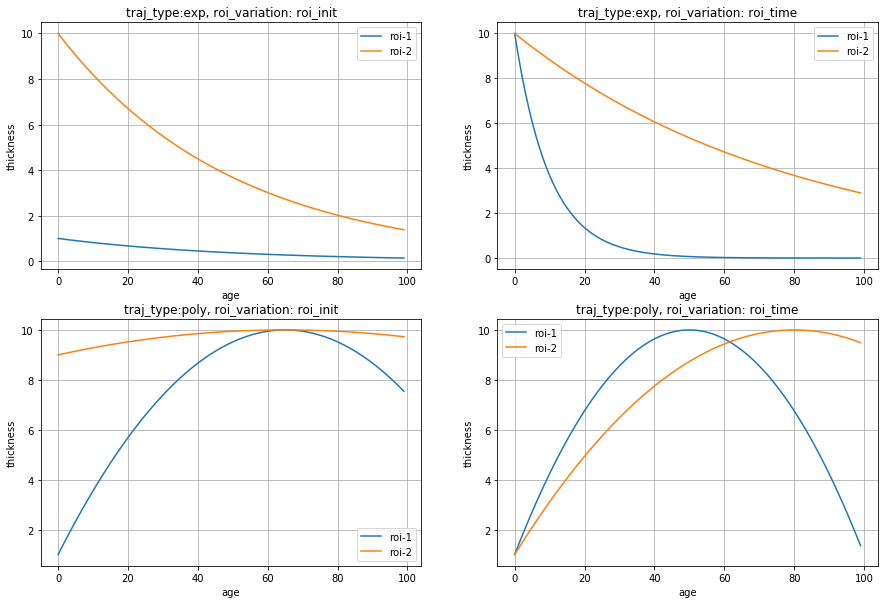

In [2]:
n_timepoints = 100
t = np.arange(n_timepoints)

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(15,10), sharey=False, sharex=False)

func_type_list = ["exp", "poly"]
func_param_list = ["roi_init", "roi_time"]

for f, func_type in enumerate(func_type_list):
    for g, func_param in enumerate(func_param_list):
        if func_type == "exp":
            if func_param == "roi_init":
                func_params1 = {"init_val": 1, "decay": 50}
                func_params2 = {"init_val": 10, "decay": 50}
            else:
                func_params1 = {"init_val": 10, "decay": 10}
                func_params2 = {"init_val": 10, "decay": 80}

        else:
            if func_param == "roi_init":
                func_params1 = {"init_val": 1, "peak_val": 10, "time_shift": 65, "poly_order": 2}
                func_params2 = {"init_val": 9, "peak_val": 10, "time_shift": 65, "poly_order": 2}
            else:
                func_params1 = {"init_val": 1, "peak_val": 10, "time_shift": 50, "poly_order": 2}
                func_params2 = {"init_val": 1, "peak_val": 10, "time_shift": 80, "poly_order": 2}

        traj1 = get_brain_trajectory(n_timepoints,func_type, func_params1)
        traj2 = get_brain_trajectory(n_timepoints,func_type, func_params2)

        ax = axes[f,g]
        ax.plot(t,traj1, label="roi-1")
        ax.plot(t,traj2, label="roi-2")
        ax.set_xlabel("age")
        ax.set_ylabel("thickness")
        ax.legend()
        ax.grid()
        ax.set_title(f"traj_type:{func_type}, roi_variation: {func_param}")

## Generate subject-specific random samples 
### Additive initial factor: subject variability

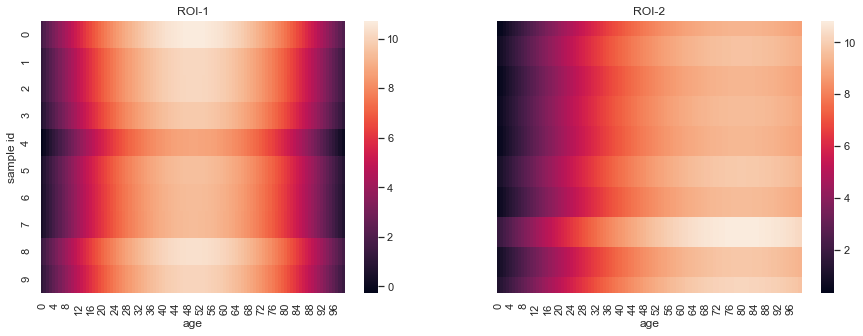

In [4]:
# same init factor for each ROI
n_samples = 10
intersubject_std = 0.5

roi_1 = get_traj_samples(traj1, n_samples, intersubject_std)
roi_2 = get_traj_samples(traj2, n_samples, intersubject_std)

palette = 'husl'
sns.set(font_scale=1)

fig, axes = plt.subplots(1,2,figsize=(15,5),sharex=True,sharey=True)
with sns.axes_style("whitegrid"):    
    ax = axes[0]
    g = sns.heatmap(roi_1, ax=ax)
    g.set_xlabel("age")
    g.set_ylabel("sample id")
    g.set_title("ROI-1")
    ax = axes[1]
    g = sns.heatmap(roi_2, ax=ax)
    g.set_title("ROI-2")
    g.set_xlabel("age")

## Extract cross-sectional samples


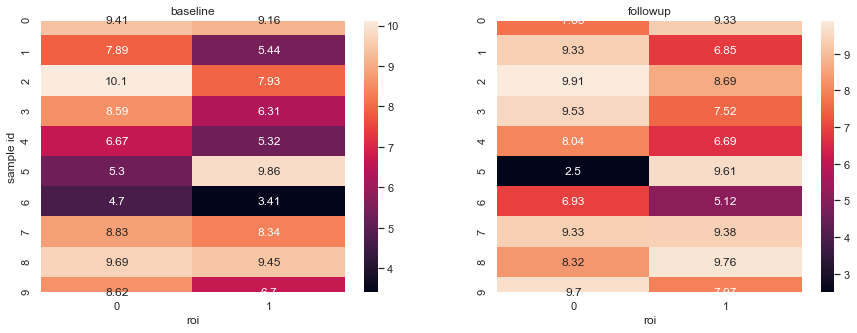

In [5]:
roi_list = [roi_1,roi_2]
y_baseline, X_baseline, X_followup = get_cross_sectional_samples(roi_list, followup_interval=10)
fig, axes = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
with sns.axes_style("whitegrid"):    
    ax = axes[0]
    g = sns.heatmap(X_baseline, annot=True, fmt=".3g", ax=ax)
    g.set_xlabel("roi")
    g.set_ylabel("sample id")
    g.set_title("baseline")
    ax = axes[1]
    g = sns.heatmap(X_followup,annot=True, fmt=".3g", ax=ax)
    g.set_title("followup")
    g.set_xlabel("roi")

time_diff mean: 0.17821818181818186, std: 0.10289431310534845
indiv_diff mean: 0.4652213457634655, std: 0.37833735453483874


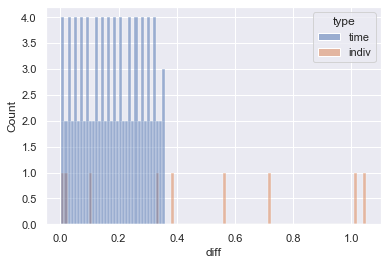

In [6]:
time_diff = abs(traj1[1:] - traj1[:-1])
indiv_diff = abs(roi_1[:,0][1:] - roi_1[:,0][:-1])

print(f"time_diff mean: {np.mean(time_diff)}, std: {np.std(time_diff)}")
print(f"indiv_diff mean: {np.mean(indiv_diff)}, std: {np.std(indiv_diff)}")

t_df = pd.DataFrame()
i_df = pd.DataFrame()
t_df["diff"] = time_diff
t_df["type"] = "time"
i_df["diff"] = indiv_diff
i_df["type"] = "indiv"
plot_df = t_df.append(i_df)

sns.histplot(x="diff",bins=100,hue="type",data=plot_df)

## Run entire toy example

In [3]:
# Traj params (Fixed)

n_timepoints = 100

func_type_list = ["exp", "poly"]
func_param_list = ["roi_init", "roi_time"]

intersubject_std_list = [0.5]
n_samples_list = [1000]
n_regions_list = [1000]
followup_list = [2]
n_iterations = 1

batch_size = 25
data_aug = True
verbose = False
n_jobs = 4

perf_df = pd.DataFrame()

for it in np.arange(n_iterations):
    for func_type in func_type_list:
        for shift_param in func_param_list:            
            for intersubject_std in intersubject_std_list:
                for followup_interval in followup_list:
                    for n_samples in n_samples_list:
                        for n_regions in n_regions_list: 
                            # Model configs (need to initialized for each data config)
                            model_dict = {
                                "Ridge": Ridge(), 
                                "RF": RandomForestRegressor(n_jobs=n_jobs, random_state=1), 
                                # "GB": GradientBoostingRegressor(random_state=1)
                                "LSN": None,
                                # "LSN1": None,
                                # "LSN2": None,
                                # "LSN3": None
                            }

                            # Get traj(s): subject values are shifted in intercept
                            traj_list = []
                            if func_type == "exp":
                                init_val = 10 # same as peak val i.e. max thickness
                                init_val_min = 1
                                init_val_max = 10 
                                
                                decay_min = 10
                                decay_max = 80
                                decay = 50

                                # Region values decay in time
                                decay_list = np.linspace(start=decay_min, stop=decay_max, num=n_regions)
                                init_val_list = np.linspace(start=init_val_min, stop=init_val_max, num=n_regions)

                                if shift_param == "roi_time":
                                    for decay in decay_list:
                                        func_params = {"init_val": init_val, "decay": decay}
                                        traj_list.append(get_brain_trajectory(n_timepoints, func_type, func_params))
                                elif shift_param == "roi_init":
                                    for init_val in init_val_list:
                                        func_params = {"init_val": init_val, "decay": decay}
                                        traj_list.append(get_brain_trajectory(n_timepoints, func_type, func_params))
                                else:
                                    for init_val, decay in zip(init_val_list, decay_list):
                                        func_params = {"init_val": init_val, "decay": decay}
                                        traj_list.append(get_brain_trajectory(n_timepoints, func_type, func_params))

                            elif func_type == "poly":
                                init_val = 1 
                                init_val_min = 1
                                init_val_max = 9

                                peak_val = 10 #max thickness 
                                
                                roi_maturity = 65
                                roi_maturity_min = 50
                                roi_maturity_max = 80

                                # Region values are shifted in time
                                roi_maturity_list = np.linspace(start=roi_maturity_min,stop=roi_maturity_max,num=n_regions)
                                init_val_list = np.linspace(start=init_val_min,stop=init_val_max,num=n_regions)

                                if shift_param == "roi_time":
                                    for roi_maturity in roi_maturity_list:
                                        func_params = {"init_val": init_val, "peak_val": peak_val, "time_shift": roi_maturity, "poly_order": 2}
                                        traj_list.append(get_brain_trajectory(n_timepoints, func_type, func_params))

                                elif shift_param == "roi_init":
                                    for init_val in init_val_list:
                                        func_params = {"init_val": init_val, "peak_val": peak_val, "time_shift": roi_maturity, "poly_order": 2}
                                        traj_list.append(get_brain_trajectory(n_timepoints, func_type, func_params))

                                else:
                                    for time_shift, init_val in zip(roi_maturity_list, init_val_list):
                                        func_params = {"init_val": init_val, "peak_val": peak_val, "time_shift": time_shift, "poly_order": 2}
                                        traj_list.append(get_brain_trajectory(n_timepoints, func_type, func_params))

                            else:
                                print(f"Unknown func type: {func_type}")

                            # Get roi samples
                            roi_list = [get_traj_samples(traj, n_samples, intersubject_std) for traj in traj_list]

                            # Get cross-sectional time data (sample with replacement)
                            y_baseline, X_baseline, X_followup = get_cross_sectional_samples(roi_list, followup_interval=followup_interval)

                            # normalize y
                            y_followup = y_baseline + followup_interval
                            y_baseline = y_baseline/100
                            y_followup = y_followup/100

                            if followup_interval > 0:                
                                X = np.hstack([X_baseline,X_followup])
                                y = np.vstack([y_baseline,y_followup]).T
                            else:
                                X = X_baseline
                                y = y_baseline
                                
                            # Split for CV and held-out test set
                            n_CV = int(0.75 * len(y))
                            
                            X_CV = X[:n_CV]
                            X_test = X[n_CV:]
                            y_CV = y[:n_CV]
                            y_test = y[n_CV:]

                            if data_aug:
                                print("Augmenting data (4x) using combinations")
                                X_baseline_CV = X_baseline[:n_CV]
                                X_followup_CV = X_followup[:n_CV]
                                y_baseline_CV = y_baseline[:n_CV]
                                y_followup_CV = y_followup[:n_CV]
                                
                                X_orig = np.hstack([X_baseline_CV,X_followup_CV])
                                y_orig = np.vstack([y_baseline_CV,y_followup_CV]).T
                                
                                # swap timepoints
                                X_swap = np.hstack([X_followup_CV, X_baseline_CV])
                                y_swap = np.vstack([y_followup_CV, y_baseline_CV]).T
                                
                                # # baseline only
                                X_base = np.hstack([X_baseline_CV, X_baseline_CV])
                                y_base = np.vstack([y_baseline_CV, y_baseline_CV]).T

                                # followup only
                                X_follow = np.hstack([X_followup_CV, X_followup_CV])
                                y_follow = np.vstack([y_followup_CV, y_followup_CV]).T

                                X_CV = np.vstack([X_orig,X_swap])
                                y_CV = np.vstack([y_orig,y_swap])

                                # manual shuffle
                                aug_idx = np.arange(y_CV.shape[0])
                                np.random.shuffle(aug_idx) 
                                X_CV = X_CV[aug_idx]
                                y_CV = y_CV[aug_idx]

                                # X_CV = np.vstack([X_orig,X_swap,X_base,X_follow])
                                # y_CV = np.vstack([y_orig,y_swap,y_base,y_follow])


                            if verbose:
                                print(f"CV data shapes, X:{X_CV.shape}, y:{y_CV.shape}")
                                print(f"CV data means, X: {np.mean(X_CV):3.2f}, y:{np.mean(y_CV):3.2f}")

                                print(f"test data shapes, X:{X_test.shape}, y:{y_test.shape}")
                                print(f"test data means, X: {np.mean(X_test):3.2f}, y:{np.mean(y_test):3.2f}")

                            # Run Models
                            for model_name, model_instance in model_dict.items():
                                print(f"\nSim config: iter: {it}, intersubject_std: {intersubject_std}, followup: {followup_interval}, n_samples: {n_samples}, n_regions= {n_regions}, model: {model_name}")
                                print(f"traj func type: {func_type}, shift param: {shift_param}")

                                if model_name in ["LSN","LSN1","LSN2","LSN3"]:
                                    # train
                                    # if model_name == "LSN1":
                                    #     hidden_size = 10
                                    # elif model_name == "LSN2":
                                    #     hidden_size = 50
                                    # elif model_name == "LSN3":
                                    #     hidden_size = 100
                                    # else:
                                    #     hidden_size = 25

                                    hidden_node_list = [10,50,100]
                                    trained_model_list = []
                                    train_loss_list = []
                                    for hidden_size in hidden_node_list:
                                        train_dataset = SimDataset(X_CV[:,:n_regions], X_CV[:,n_regions:], y_CV[:,0], y_CV[:,1])
                                        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                                    
                                        model = LSN(X_baseline.shape[1],hidden_size=hidden_size) # alternative toy model: LSN()

                                        # model = torch.nn.DataParallel(model)
                                        model.train()
                                            
                                        optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.5)
                                        # optimizer = optim.Adam(model.parameters(), lr=0.001)
                                        criterion = nn.MSELoss()
                                        n_epochs = 300

                                        model, batch_loss_df, epoch_loss_df = train(model,train_dataloader,optimizer,criterion,n_epochs)
                                        train_loss = epoch_loss_df["epoch_loss"].values[-1]
                                        train_loss_list.append(train_loss)
                                        trained_model_list.append(model)
                                        
                                    # pick the best model
                                    opt_model_idx = np.argmin(train_loss_list)
                                    train_loss = np.min(train_loss_list)
                                    model = trained_model_list[opt_model_idx]

                                    # test
                                    test_dataset = SimDataset(X_test[:,:n_regions], X_test[:,n_regions:], y_test[:,0], y_test[:,1])
                                    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

                                    model.eval()                    
                                    batch_pred_list, loss1_list, loss2_list = test(model, test_dataloader)
                                    batch_pred_array = np.vstack(np.squeeze(batch_pred_list))
                                    
                                    r1 = stats.pearsonr(batch_pred_array[:,0],y_test[:,0])[0]
                                    r2 = stats.pearsonr(batch_pred_array[:,1],y_test[:,1])[0]
                                    
                                    df = pd.DataFrame()
                                    df["eid"] = np.arange(len(y_test))
                                    df["test_age_1"] = 100*y_test[:,0]
                                    df["test_age_2"] = 100*y_test[:,1]
                                    df["test_brainage_1"] = batch_pred_array[:,0]
                                    df["test_brainage_2"] = batch_pred_array[:,1]
                                    df["test_MAE1"] = loss1_list
                                    df["test_MAE2"] = loss2_list
                                    df["test_r1"] = r1
                                    df["test_r2"] = r2
                                    df["CV_score"] = train_loss
                                    df["model"] = model_name
                                    df["n_samples"] = n_samples
                                    df["n_regions"] = n_regions
                                    df["followup_interval"] = followup_interval   
                                    df["intersubject_std"] = intersubject_std
                                    df["func_type"] = func_type
                                    df["shift_param"] = shift_param
                                    df["iter"] = it
                                    
                                    perf_df = perf_df.append(df)

                                else:
                                    CV_scores, y_pred, test_MAE1, test_MAE2, test_r1, test_r2 = get_brain_age_perf(X_CV, y_CV, X_test, y_test, model_instance)
                                    # print(f"CV / train MSE: {np.mean(-1*CV_scores):5.4f}")
                                    df = pd.DataFrame()
                                    df["eid"] = np.arange(len(y_test))
                                    df["test_age_1"] = 100*y_test[:,0]
                                    df["test_age_2"] = 100*y_test[:,1]
                                    df["test_brainage_1"] = y_pred[:,0]
                                    df["test_brainage_2"] = y_pred[:,1]
                                    df["test_MAE1"] = test_MAE1                    
                                    df["test_MAE2"] = test_MAE2
                                    df["test_r1"] = test_r1
                                    df["test_r2"] = test_r2
                                    df["CV_score"] = np.mean(-1*CV_scores) #negative MSE
                                    df["model"] = model_name
                                    df["n_samples"] = n_samples
                                    df["n_regions"] = n_regions
                                    df["followup_interval"] = followup_interval   
                                    df["intersubject_std"] = intersubject_std
                                    df["func_type"] = func_type
                                    df["shift_param"] = shift_param
                                    df["iter"] = it

                                    perf_df = perf_df.append(df)



Augmenting data (4x) using combinations

Sim config: iter: 0, intersubject_std: 0.5, followup: 2, n_samples: 1000, n_regions= 1000, model: Ridge
traj func type: exp, shift param: roi_init

Sim config: iter: 0, intersubject_std: 0.5, followup: 2, n_samples: 1000, n_regions= 1000, model: RF
traj func type: exp, shift param: roi_init

Sim config: iter: 0, intersubject_std: 0.5, followup: 2, n_samples: 1000, n_regions= 1000, model: LSN
traj func type: exp, shift param: roi_init
Augmenting data (4x) using combinations

Sim config: iter: 0, intersubject_std: 0.5, followup: 2, n_samples: 1000, n_regions= 1000, model: Ridge
traj func type: exp, shift param: roi_time

Sim config: iter: 0, intersubject_std: 0.5, followup: 2, n_samples: 1000, n_regions= 1000, model: RF
traj func type: exp, shift param: roi_time

Sim config: iter: 0, intersubject_std: 0.5, followup: 2, n_samples: 1000, n_regions= 1000, model: LSN
traj func type: exp, shift param: roi_time
Augmenting data (4x) using combinations

S

In [ ]:
print(f"perf df shape: {perf_df.shape}, expected: {4*0.25*(it+1)*np.sum(n_samples_list)*len(intersubject_std_list)*len(model_dict)*len(n_regions_list)*len(followup_list)}")
perf_df.head()

## Plot MAE

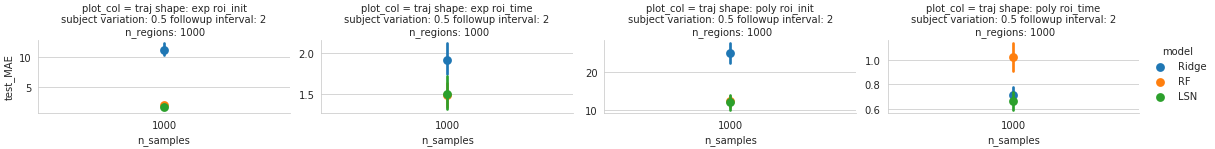

In [4]:
if n_iterations > 1:
    plot_df = perf_df.groupby(["model", "n_samples", "n_regions", "followup_interval", "intersubject_std", "iter"]).mean().reset_index().copy()
else:
    plot_df = perf_df.copy()


func_type = "exp"
shift_param = "roi_time"
intersubject_std = 0.5
followup_interval = 2

plot_df["plot_col"] = "traj shape: " + plot_df['func_type'] + " " + plot_df['shift_param'] + \
                      "\nsubject variation: " + plot_df['intersubject_std'].astype(str) + " " + \
                      "followup interval: " + plot_df['followup_interval'].astype(str) + "\n n_regions: " + plot_df['n_regions'].astype(str)

# plot_df = plot_df[(plot_df["func_type"]==func_type) & (plot_df["shift_param"]==shift_param)] 
# plot_df = plot_df[(plot_df["intersubject_std"]==intersubject_std) & (plot_df["followup_interval"]==followup_interval)]

plot_df["test_MAE"] = 0.5 * (plot_df["test_MAE1"] + plot_df["test_MAE1"])
plot_df["test_r"] = 0.5 * (plot_df["test_r1"] +plot_df["test_r1"])

with sns.axes_style("whitegrid"):
    g = sns.catplot(y="test_MAE",x="n_samples",hue="model",col="plot_col",col_wrap=4, kind="point", data=plot_df, aspect=2, height=2, sharey=False)

## Plot brainage diff

Save string for followup: 2
run2_brainage-diff_func_exp_roi-var_roi_time_subject-var_0.5


/home/nikhil/projects/green_comp_neuro/green_compute/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


test_MAE  brainage_diff  \
func_type shift_param model n_regions n_samples                             
exp       roi_init    LSN   1000      1000        1.530194       0.442625   
                      RF    1000      1000        1.944080       0.245600   
                      Ridge 1000      1000       11.288049       1.558510   
          roi_time    LSN   1000      1000        1.504542       1.645484   
                      RF    1000      1000        1.486160       0.414080   
                      Ridge 1000      1000        1.916901       1.987427   
poly      roi_init    LSN   1000      1000       12.153441       0.116335   
                      RF    1000      1000       12.428885       0.222999   
                      Ridge 1000      1000       25.073708       0.517323   
          roi_time    LSN   1000      1000        0.663901       1.724052   
                      RF    1000      1000        1.024120       0.581920   
                      Ridge 1000      1000        0.712262       1.999543   

                                                 age_diff  
func_type shift_param model n_regions n_samples            
exp       roi_init    LSN   1000      1000            2.0  
                      RF    1000      1000            2.0  
                      Ridge 1000      1000            2.0  
          roi_time    LSN   1000      1000            2.0  
                      RF    1000      1000            2.0  
                      Ridge 1000      1000            2.0  
poly      roi_init    LSN   1000      1000            2.0  
                      RF    1000      1000            2.0  
                      Ridge 1000      1000            2.0  
          roi_time    LSN   1000      1000            2.0  
                      RF    1000      1000            2.0  
                      Ridge 1000      1000            2.0

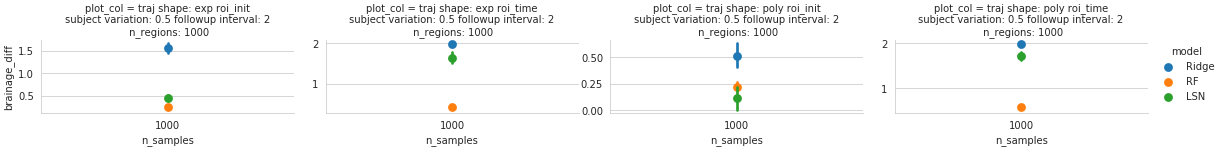

In [7]:
plot_df["age_diff"] = plot_df["test_age_2"] - plot_df["test_age_1"]
plot_df["brainage_diff"] = plot_df["test_brainage_2"] - plot_df["test_brainage_1"]

print(f"Save string for followup: {followup_interval}")
print(f"run2_brainage-diff_func_{func_type}_roi-var_{shift_param}_subject-var_{intersubject_std}")

with sns.axes_style("whitegrid"):
    g = sns.catplot(y="brainage_diff",x="n_samples",hue="model",col="plot_col",col_wrap=4, kind="point", data=plot_df, aspect=2, height=2, sharey=False)

plot_df.groupby(["func_type", "shift_param","model","n_regions","n_samples"])["test_MAE","brainage_diff","age_diff"].mean()

## Plot subject-var for given sample and regions sizes

In [18]:
plot_df = perf_df.copy()

func_type = "poly"
shift_param = "roi_init"
# intersubject_std = 0.1
# followup_interval = 2

plot_df = plot_df[(plot_df["func_type"]==func_type) & (plot_df["shift_param"]==shift_param)] 
plot_df = plot_df[(plot_df["n_samples"]==100) & (plot_df["n_regions"]==10)] 

plot_df["test_MAE"] = 0.5 * (plot_df["test_MAE1"] + plot_df["test_MAE1"])
plot_df["test_r"] = 0.5 * (plot_df["test_r1"] + plot_df["test_r1"])

print(f"Save string for followup: {followup_interval}")
# print(f"run2_MAE_func_{func_type}_roi-var_{shift_param}_subject-var_{intersubject_std}")

with sns.axes_style("whitegrid"):
    g = sns.catplot(y="test_MAE",x="intersubject_std",hue="model",col="followup_interval", kind="point", data=plot_df, aspect=1)

Save string for followup: 10


ValueError: min() arg is an empty sequence

,epoch_loss
0,0.024597
1,0.002840
2,0.000462
3,0.000372
4,0.000351
...,...
295,0.000070
296,0.000070
297,0.000070
298,0.000068


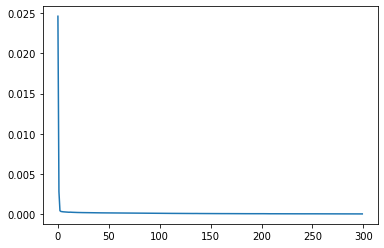

In [19]:
# perf_df.to_csv("results/simulation/brain_diff_sim_twinmodels_data_aug_success_run.csv")
# 
# LSN_df = pd.read_csv("results/simulation/brain_diff_sim_LSN_run_1.csv")
# base_df = pd.read_csv("results/simulation/brain_diff_sim_basemodels_run_2.csv")
# LSN_df = perf_df.copy()

plt.plot(epoch_loss_df)
epoch_loss_df

## Plots

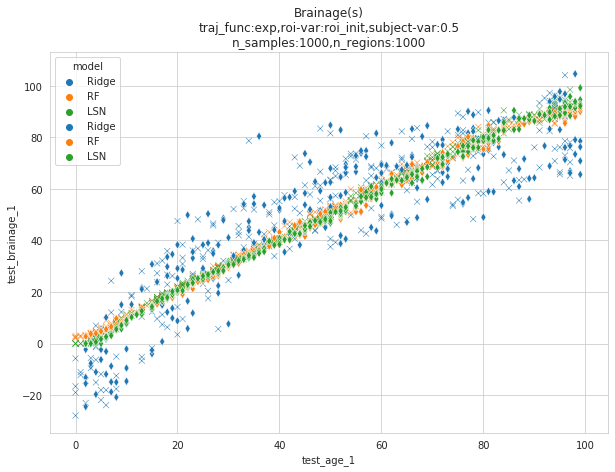

In [20]:
plot_df = perf_df.copy()
func_type = "exp"
shift_param = "roi_init"
intersubject_std = 0.5
followup_interval = 2
n_samples = 1000
n_regions = 1000

plot_df = plot_df[(plot_df["func_type"]==func_type) & (plot_df["shift_param"]==shift_param)] 
plot_df = plot_df[(plot_df["intersubject_std"]==intersubject_std) & (plot_df["followup_interval"]==followup_interval)]
plot_df = plot_df[(plot_df["n_samples"]==n_samples) & (plot_df["n_regions"]==n_regions)] 

plot_df = plot_df[plot_df["model"].isin(["Ridge","RF","LSN"])]

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,7))
    g = sns.scatterplot(x="test_age_1",y="test_brainage_1",hue="model", marker="x", data=plot_df, ax=ax)
    g = sns.scatterplot(x="test_age_2",y="test_brainage_2",hue="model", marker="d", data=plot_df, ax=ax)

    ax.set_title(f"Brainage(s)\ntraj_func:{func_type},roi-var:{shift_param},subject-var:{intersubject_std}\nn_samples:{n_samples},n_regions:{n_regions}")
